Computed firing angle (deg) = 0.291


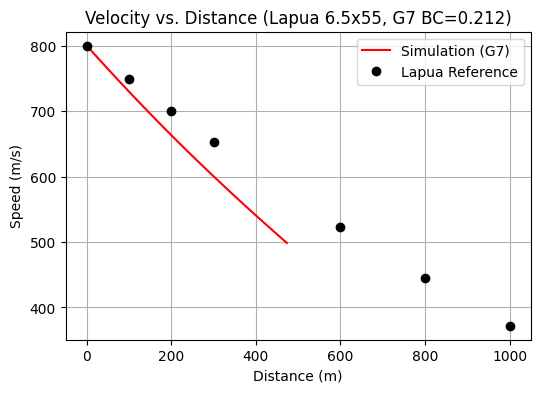

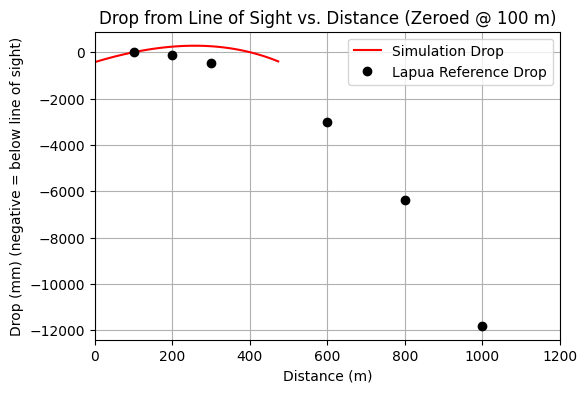

Final time: 0.75 s
Max distance reached in simulation: 473.4 m
Final speed: 498.5 m/s


In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Imports from your 'sim' module, which must define G7 as an Nx2 array: [Mach, Kd].
from sim import G7 as G7_TABLE

###############################################################################
# Euler-Richardson integrator and the ODE system
###############################################################################
def EulerRichardson(dt, f, t, y, args):
    k1 = f(t, y, *args)
    y_mid = y + k1*(dt/2)
    k2 = f(t + dt/2, y_mid, *args)
    return y + k2*dt

def solve_ode(f, tspan, y0, method, obj, first_step=0.01):
    t0, tf = tspan
    dt = first_step
    ts = [t0]
    ys = [y0]
    while ts[-1] < tf:
        t_cur = ts[-1]
        y_cur = ys[-1]
        y_new = method(dt, f, t_cur, y_cur, (obj,))
        t_new = t_cur + dt
        ts.append(t_new)
        ys.append(y_new)
        # Stop if bullet goes below ground
        if y_new[1] <= 0:
            break
    return np.array(ts), np.array(ys)

def projectile_ode(t, state, ballistic_obj):
    x, y, vx, vy = state
    speed = math.sqrt(vx*vx + vy*vy)
    if speed < 1e-12:
        speed = 1e-12

    drag_accel = ballistic_obj.get_drag(speed)
    g = ballistic_obj.g
    ux = vx / speed
    uy = vy / speed

    ax = -drag_accel * ux
    ay = g - drag_accel * uy
    return np.array([vx, vy, ax, ay])

###############################################################################
# BallisticModel class
###############################################################################
class BallisticModel:
    def __init__(self,
                 bc_imperial,       # ballistic coefficient in lb/in^2
                 drag_table,        # e.g. G7_TABLE from sim
                 muzzle_velocity,   # m/s
                 scope_offset=0.04, # 40 mm scope height => bore is -0.04 m
                 rho=1.225,         # kg/m^3
                 speed_of_sound=343.0,  # m/s
                 g=-9.81):
        # Convert BC from lb/in^2 to kg/m^2
        self.bc = bc_imperial * 703.24
        self.drag_table = drag_table
        self.muzzle_velocity = muzzle_velocity
        self.x0 = 0.0
        self.y0 = -scope_offset  # barrel ~0.04 m below scope line
        self.rho = rho
        self.speed_of_sound = speed_of_sound
        self.g = g

        # Convert drag table from Kd to Cd => Cd = (π/4)*Kd
        mach_vals = self.drag_table[:,0]
        kd_vals = self.drag_table[:,1]
        cd_vals = (math.pi / 4.0)*kd_vals
        self.get_cd_interp = interp1d(mach_vals, cd_vals,
                                      kind='linear',
                                      fill_value='extrapolate')

        # We'll store firing angle in radians
        self.firing_angle = 0.0

    def get_drag(self, speed):
        mach = speed / self.speed_of_sound
        cd = self.get_cd_interp(mach)
        # a_d = 0.5 * (1/bc) * rho * v^2 * Cd
        return 0.5 * (1.0/self.bc) * self.rho * speed**2 * cd

    def initial_conditions(self):
        vx0 = self.muzzle_velocity * math.cos(self.firing_angle)
        vy0 = self.muzzle_velocity * math.sin(self.firing_angle)
        return np.array([self.x0, self.y0, vx0, vy0])

    def find_firing_angle_for_zero(self, zero_distance_m):
        """
        Adjust firing angle so that the bullet crosses y=0
        (the scope line) exactly at zero_distance_m.
        """
        angle_low, angle_high = 0.0, math.radians(20.0)  # 0..20 deg is typical
        for _ in range(40):
            mid = 0.5*(angle_low + angle_high)
            self.firing_angle = mid
            y0 = self.initial_conditions()
            tsim, ysim = solve_ode(projectile_ode, (0, 5), y0, EulerRichardson, self, 0.01)

            # find approximate distance of bullet crossing y=0
            # (We check final x if bullet hits ground before crossing y=0)
            final_x = ysim[-1,0]
            if final_x < zero_distance_m:
                angle_low = mid
            else:
                angle_high = mid

        self.firing_angle = 0.5*(angle_low + angle_high)


###############################################################################
# MAIN DEMO
###############################################################################
if __name__ == "__main__":
    # --- 1) Define reference data from Lapua's metric chart ---

    # Distances (m)
    ref_dist_m = np.array([0, 100, 200, 300, 600, 800, 1000])
    # Velocities at those distances (m/s):
    #  0m->800, 100m->749, 200m->700, 300m->653, 600m->523, 800m->445, 1000m->372
    ref_vel_m_s = np.array([800, 749, 700, 653, 523, 445, 372])

    # "Rifle sighted in at 100 m" => Drop from line of sight in mm:
    # Distances: [100, 200, 300, 600, 800, 1000]
    # Drop (mm): [   0, -134, -467, -2991, -6395, -11802 ]
    # Negative means below line of sight
    ref_drop_dist_m = np.array([100, 200, 300, 600, 800, 1000])
    ref_drop_mm = np.array([0, -134, -467, -2991, -6395, -11802])

    # --- 2) Create ballistic model for Lapua 6.5x55 using G7 BC=0.212 lb/in^2 ---
    bc_g7_imperial = 0.212
    muzzle_vel = 800.0
    model = BallisticModel(
        bc_imperial=bc_g7_imperial,
        drag_table=G7_TABLE,       # from sim import G7 as G7_TABLE
        muzzle_velocity=muzzle_vel,
        scope_offset=0.04,         # 40 mm above bore
        rho=1.225,
        speed_of_sound=343.0,
        g=-9.81
    )

    # --- 3) Zero the rifle at 100 m (bullet crosses y=0 at x=100) ---
    model.find_firing_angle_for_zero(100.0)
    print(f"Computed firing angle (deg) = {math.degrees(model.firing_angle):.3f}")

    # --- 4) Solve from t=0 to t=5 s (enough time to surpass 1000 m)
    state0 = model.initial_conditions()
    t_span = (0, 10000)
    t_sol, y_sol = solve_ode(projectile_ode, t_span, state0, EulerRichardson, model, first_step=0.01)

    x_vals = y_sol[:,0]
    y_vals = y_sol[:,1]
    vx_vals = y_sol[:,2]
    vy_vals = y_sol[:,3]
    speed_vals = np.sqrt(vx_vals**2 + vy_vals**2)

    # --- 5) Plot velocity vs. distance, with reference data ---
    plt.figure(figsize=(6,4))
    plt.plot(x_vals, speed_vals, 'r-', label="Simulation (G7)")
    plt.plot(ref_dist_m, ref_vel_m_s, 'ko', label="Lapua Reference")
    plt.title("Velocity vs. Distance (Lapua 6.5x55, G7 BC=0.212)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Speed (m/s)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- 6) Plot drop from line of sight vs. distance, with reference data ---
    #
    # The reference is "drop" in mm below the line of sight, where line of sight = y=0 at x=0
    # and bullet crosses y=0 again at x=100. So let's replicate that:
    #  1) find bullet's y-value at 100 m
    #  2) define bullet_drop_mm(distance) = [ y(distance) - y(100m) ]*1000
    #  3) at x=100, that drop is ~0 mm. At x>100, drop is negative => below line of sight.
    #
    # We can approximate y(100) by interpolating in x_vals,y_vals if 100 m wasn't a direct step:
    # We'll just do a direct search for the step nearest 100 m.

    # quick interpolation for bullet y at 100 m
    bullet_y_at_100 = np.interp(100.0, x_vals, y_vals)

    # Now compute drop from 100 m line of sight for all x
    bullet_drop_mm = 1000*(y_vals - bullet_y_at_100)

    plt.figure(figsize=(6,4))
    # We'll limit the x-axis to ~1200 for clarity
    plt.plot(x_vals, bullet_drop_mm, 'r-', label="Simulation Drop")
    # Overplot the reference drop points
    plt.plot(ref_drop_dist_m, ref_drop_mm, 'ko', label="Lapua Reference Drop")
    plt.title("Drop from Line of Sight vs. Distance (Zeroed @ 100 m)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Drop (mm) (negative = below line of sight)")
    plt.xlim(0, 1200)
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- 7) Print some final results ---
    max_x = x_vals[-1]
    final_speed = speed_vals[-1]
    print(f"Final time: {t_sol[-1]:.2f} s")
    print(f"Max distance reached in simulation: {max_x:.1f} m")
    print(f"Final speed: {final_speed:.1f} m/s")
